In [1]:
%run pitcher_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from tensorflow import keras

feature, target = pitcher_data("SS")

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A va

In [3]:
feature.columns

Index(['BF', 'MONEY_PIT', 'AGE_VA_PIT', 'K/9', 'BB/9', 'LOB%', 'FIP', 'DER',
       'PPF', 'ER_PCA', 'BT_PCA'],
      dtype='object')

In [65]:
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)
trainFeature.shape

(481, 13)

In [55]:
standardizer = PowerTransformer()
res = standardizer.fit(trainFeature)

res = standardizer.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = standardizer.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

In [131]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)
    
def make_model(hp) :
    model = keras.Sequential()

    model.add(keras.layers.Input(shape = (trainFeature.shape[1])))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                               activation="selu", kernel_initializer = "lecun_normal"))
        model.add(MCDropout(rate = hp.Choice("rate", values = [0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(keras.layers.Dense(1, activation = None))

    optimizer = keras.optimizers.Nadam(hp.Choice("learning_rate", values = [0.005, 0.001, 0.0005, 0.0001]))

    model.compile(optimizer = optimizer, loss = keras.losses.Huber())
    return model

tuner = kt.BayesianOptimization(make_model, objective = "val_loss", max_trials = 21, executions_per_trial = 11, project_name = "SS_pitcher")
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, mode = "min", restore_best_weights = True)

tuner.search(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True, callbacks = [early_stop], batch_size = 20)


Train on 481 samples, validate on 101 samples
Epoch 1/700
481/481 [==============================] - 3s 7ms/sample - loss: 0.5962 - val_loss: 2.5650
Epoch 2/700
481/481 [==============================] - 0s 459us/sample - loss: 0.5333 - val_loss: 1.5808
Epoch 3/700
481/481 [==============================] - 0s 419us/sample - loss: 0.5151 - val_loss: 1.8706
Epoch 4/700
481/481 [==============================] - 0s 412us/sample - loss: 0.4471 - val_loss: 0.8409
Epoch 5/700
481/481 [==============================] - 0s 419us/sample - loss: 0.4065 - val_loss: 1.3938
Epoch 6/700
481/481 [==============================] - 0s 415us/sample - loss: 0.3527 - val_loss: 1.3623
Epoch 7/700
481/481 [==============================] - 0s 433us/sample - loss: 0.3093 - val_loss: 0.3090
Epoch 8/700
481/481 [==============================] - 0s 452us/sample - loss: 0.2630 - val_loss: 0.2411
Epoch 9/700
481/481 [==============================] - 0s 455us/sample - loss: 0.2730 - val_loss: 0.1106
Epoch 10/70

In [132]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
model.summary()

0.6235727

In [133]:
result = np.zeros(shape = (20, ))
for i in range(100) :
    best = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best)
    model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True,
                    callbacks = [early_stop], batch_size = 20)
    result += model.predict(testFeature).reshape(20, )
result /= 100

0.6900106837606836

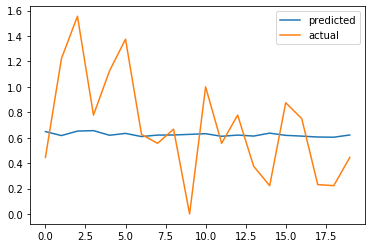

In [134]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
history = model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True, callbacks = [early_stop], batch_size = 20)
result = model.predict(testFeature)

In [ ]:
result.mean()

In [ ]:
testTarget.mean()

In [ ]:
trainTarget.mean()

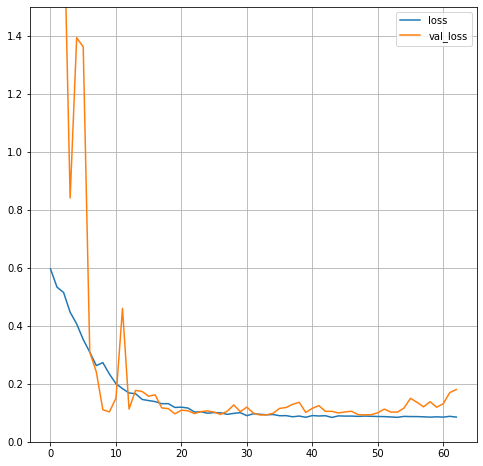

In [135]:
pd.DataFrame(history.history).plot(figsize = (8, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()